<a href="https://colab.research.google.com/github/haadirakhangi/Langgraph-Agents/blob/main/LangGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install langgraph langchain_community langchain_experimental langmem langchain-google-genai tavily-python

In [ ]:
import os
from google.colab import userdata
os.environ['GOOGLE_API_KEY'] = userdata.get("GOOGLE_API_KEY")
os.environ['TAVILY_API_KEY'] = userdata.get("TAVILY_API_KEY")

# General Chatbot

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_google_genai import ChatGoogleGenerativeAI

In [ ]:
class State(TypedDict):
  messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

In [ ]:
def chatbot(state: State):
  return {"messages": [llm.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile()

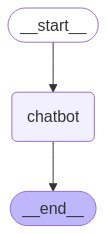

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [ ]:
graph.invoke({"messages": [{"role": "user", "content": "Hello, what is langmem?"}]})

{'messages': [HumanMessage(content='Hello, what is langmem?', additional_kwargs={}, response_metadata={}, id='863d2990-8e59-4db4-ba8c-a030fa5eee56'),
  AIMessage(content='"Langmem" isn\'t a standard or widely recognized term in the fields of linguistics, computer science, or memory research. It\'s possible it could be:\n\n*   **A typo:** Perhaps you meant something else.\n*   **A specific project name:** If it\'s the name of a software tool, research project, or specific application, it would be more context-dependent.\n*   **A neologism or slang term:** It might be a newly coined word or a term used within a very specific, smaller group of people.\n\nIf you can provide more context about where you encountered this term, I might be able to give you a more accurate answer. For example:\n\n*   Where did you see or hear the term "langmem"?\n*   What was the context in which it was used?\n*   What were you reading/watching/listening to when you encountered it?\n\nWithout more information, 

### ADDING MEMORY AND TOOLS

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults
tool = TavilySearchResults(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)

In [ ]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [ ]:
class State(TypedDict):
  messages : Annotated[list, add_messages]

def chatbot(state: State):
  return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [ ]:
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("tools", "chatbot")
graph = graph_builder.compile(checkpointer=memory)

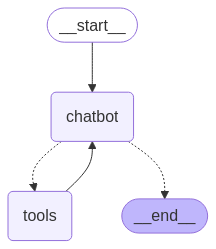

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [ ]:
config = {"configurable": {"thread_id": "1"}}

In [ ]:
events = graph.stream(
    {"messages": [{"role": "user", "content": "What is langchain?"}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is langchain?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (bb1fb81a-c8c8-435b-acf9-f76ac54cb1b5)
 Call ID: bb1fb81a-c8c8-435b-acf9-f76ac54cb1b5
  Args:
    query: what is langchain?
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "What Is LangChain? - IBM", "url": "https://www.ibm.com/think/topics/langchain", "content": "What Is LangChain? | IBM\nWhat is LangChain?\nArtificial Intelligence\n31 October 2023\nLink copied\nWhat is LangChain?\nLangChain is an open source orchestration framework for the development of applications using large language models (LLMs). Available in both Python- and Javascript-based libraries, LangChain’s tools and APIs simplify the process of building LLM-driven applications like chatbots and virtual agents. [...] LangCha

In [ ]:
events = graph.stream(
    {"messages": [{"role": "user", "content": "What was the last question that I asked you?"}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What was the last question that I asked you?
================================== Ai Message ==================================

The last question you asked me was "What is langchain?".


In [ ]:
events = graph.stream(
    {"messages": [{"role": "user", "content": "What is Langmem?"}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is Langmem?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (4d03c3c2-2cbc-4d5f-95b5-8b7735ddc66d)
 Call ID: 4d03c3c2-2cbc-4d5f-95b5-8b7735ddc66d
  Args:
    query: What is LangMem?
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "LangMem: Long-Term Memory for AI Agents | by Astropomeai", "url": "https://medium.com/@astropomeai/langmem-long-term-memory-for-ai-agents-366d7256ddce", "content": "LangMem is a software development kit (SDK) from LangChain designed to give AI agents long-term memory. It enables an agent to learn and adapt from its interactions over time, storing important information from conversations, refining its prompts/behavior, and maintaining knowledge across sessions. In essence, LangMem helps an AI agent remember user preferences, 

### WITHOUT TOOLS_CONDITION

In [ ]:
class State(TypedDict):
  messages : Annotated[list, add_messages]

graph_builder = StateGraph(State)

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
tool = TavilySearchResults(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)

def call_model(state: State):
  return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", call_model)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

def should_continue(state: State):
  if state["messages"][-1].tool_calls:
    return "tools"
  return END

graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges("chatbot", should_continue, ["tools", END])
graph_builder.add_edge("tools", "chatbot")

memory = MemorySaver()
app = graph_builder.compile(checkpointer = memory)

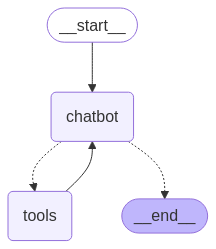

In [ ]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
for chunk in app.stream(
    {"messages": [("human", "what's the weather in sf?")]}, {"configurable":{"thread_id":"1"}},stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

what's the weather in sf?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (ff00a747-dcf7-46a9-be24-3b3430c274ef)
 Call ID: ff00a747-dcf7-46a9-be24-3b3430c274ef
  Args:
    query: weather in San Francisco
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Weather in San Francisco", "url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'San Francisco', 'region': 'California', 'country': 'United States of America', 'lat': 37.775, 'lon': -122.4183, 'tz_id': 'America/Los_Angeles', 'localtime_epoch': 1743253650, 'localtime': '2025-03-29 06:07'}, 'current': {'last_updated_epoch': 1743253200, 'last_updated': '2025-03-29 06:00', 'temp_c': 8.9, 'temp_f': 48.0, 'is_day': 0, 'condition': {'text': 'Partly cloudy', 'icon': '//cdn.weatherapi.com/weather/6

### ADDING SEMANTIC PROFILE MEMORY

In [ ]:
from langmem import create_memory_manager
from pydantic import BaseModel

class UserProfile(BaseModel):
  "Save the user's preferences"
  name: str
  preferred_name: str
  response_style_preference: str
  special_skills: list[str]
  other_preferences: list[str]

manager = create_memory_manager(
    llm,
    schemas=[UserProfile],
    instructions="Extract user preferences and settings",
    enable_inserts=False,
)

conversation = [
    {"role": "user", "content": "Hi! I'm Alex but please call me Lex. I'm a wizard at Python and love making AI systems that don't sound like boring corporate robots 🤖"},
    {"role": "assistant", "content": "Nice to meet you, Lex! Love the anti-corporate-robot stance. How would you like me to communicate with you?"},
    {"role": "user", "content": "Keep it casual and witty - and maybe throw in some relevant emojis when it feels right ✨ Also, besides AI, I do competitive speedcubing!"},
]

In [ ]:
manager.invoke({"messages": conversation})

[ExtractedMemory(id='61f2f0b4-5a7a-4fc0-b5bb-1b56fd119686', content=UserProfile(name='Alex', preferred_name='Lex', response_style_preference='casual and witty with relevant emojis', special_skills=['Python', 'AI systems'], other_preferences=['anti-corporate-robot AI', 'competitive speedcubing']))]

In [ ]:
profile = manager.invoke({"messages": conversation})[0]

In [ ]:
profile

ExtractedMemory(id='5a63a556-a861-4cb9-beb7-b8e91a8a00c0', content=UserProfile(name='Alex', preferred_name='Lex', response_style_preference='casual and witty with emojis', special_skills=['Python', 'AI systems'], other_preferences=['anti-corporate-robot AI', 'competitive speedcubing']))

In [ ]:
profile.content

UserProfile(name='Alex', preferred_name='Lex', response_style_preference='casual and witty with emojis', special_skills=['Python', 'AI systems'], other_preferences=['anti-corporate-robot AI', 'competitive speedcubing'])

In [ ]:
str(profile.content)

"name='Alex' preferred_name='Lex' response_style_preference='casual and witty with emojis' special_skills=['Python', 'AI systems'] other_preferences=['anti-corporate-robot AI', 'competitive speedcubing']"

### DESIGNING A PERSONALIZED CHATBOT

In [ ]:
from langchain_core.tools import tool
from langmem import create_memory_store_manager
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langgraph.store.memory import InMemoryStore
from langgraph.func import entrypoint
from langgraph.config import get_config
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
from pydantic import BaseModel

In [ ]:
embeddings = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-exp-03-07")
len(embeddings.embed_query("What's our Q1 revenue?"))

3072

In [ ]:
embeddings = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")
len(embeddings.embed_query("What's our Q1 revenue?"))

768

In [ ]:
class UserProfile(BaseModel):
  "Save the user's preferences"
  name: str
  preferred_name: str
  response_style_preference: str
  special_skills: list[str]
  other_preferences: list[str]

store = InMemoryStore(
    index={
        "dims":3072,
        "embed":embeddings
    }
)

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

manager = create_memory_store_manager(
    llm,
    namespace=("users", "{user_id}", "profile"),
    schemas=[UserProfile],
    enable_inserts=False
)

@entrypoint(store=store)
def chat(messages: list):
  configurable = get_config()["configurable"]
  results = store.search(
      ("users", configurable["user_id"], "profile")
  )
  profile = None
  if results:
      profile = f"""<User Profile>:
{results[0].value}
</User Profile>
"""

  response = llm.invoke([
      {
          "role": "system",
          "content": f"""You are a helpful assistant.{profile}"""
      },
      *messages
  ])

  manager.invoke({"messages": messages})
  return response

In [ ]:
# Example usage
await chat.ainvoke(
    [{"role": "user", "content": "I'm Alice from California"}],
    config={"configurable": {"user_id": "user-123"}}
)

await chat.ainvoke(
    [{"role": "user", "content": "I just passed the N1 exam!"}],
    config={"configurable": {"user_id": "user-123"}}
)

print(store.search(("users", "user-123", "profile")))

[Item(namespace=['users', 'user-123', 'profile'], key='36703273-7dc1-4cb0-87e0-e1752c2687c0', value={'kind': 'UserProfile', 'content': {'name': 'Alice', 'preferred_name': 'Alice', 'response_style_preference': '', 'special_skills': ['Passed N1 Exam'], 'other_preferences': ['From California']}}, created_at='2025-03-30T00:02:35.846012+00:00', updated_at='2025-03-30T00:02:35.846020+00:00', score=None)]


Implementation of our personalized chatbot

In [ ]:
from typing import Dict, Any, List
from pydantic import BaseModel

class UserProfile(BaseModel):
  "Save the user's preferences"
  name: str
  preferred_name: str
  response_style_preference: str
  special_skills: list[str]
  other_preferences: list[str]

store = InMemoryStore(
    index={
        "dims":3072,
        "embed": GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-exp-03-07")
    }
)

manager = create_memory_store_manager(
    llm,
    namespace=("users", "{user_id}", "profile"),
    schemas=[UserProfile],
    enable_inserts=False,
    store=store,
)

class State(TypedDict):
  messages : Annotated[list, add_messages]

@tool
def update_user_profile(messages: str) -> str:
  """Call to update the user's profile consisting of user's name, preferred name,
    response style preference, special skills, and other preferences.

    Args:
        messages : A string containing all the user's messages to use for profile update

    Returns:
        A string describing the profile update"""
  print("I AM HERE")
  conversation = [
    {"role": "user", "content": "Hi! I'm Alex but please call me Lex. I'm a wizard at Python and love making AI systems that don't sound like boring corporate robots 🤖"},
    {"role": "assistant", "content": "Nice to meet you, Lex! Love the anti-corporate-robot stance. How would you like me to communicate with you?"},
    {"role": "user", "content": "Keep it casual and witty - and maybe throw in some relevant emojis when it feels right ✨ Also, besides AI, I do competitive speedcubing!"},
]
  updated_profile = manager.invoke({"messages": conversation})
  print("UPDATED PROFILE", updated_profile)
  return "User Profile updated: " + str(updated_profile[0]["value"]["content"])

tools = [update_user_profile]
tool_node=ToolNode(tools=tools)
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
llm_with_tools = llm.bind_tools(tools)
memory = MemorySaver()

@entrypoint(store=store)
def call_model(state : State):
  configurable = get_config()["configurable"]
  results = store.search(
      ("users", configurable["user_id"], "profile")
  )
  profile= None
  if results:
    profile = f"""<User Profile>:
{results[0].value}
</User Profile>
"""
  print("BEFORE RESPONSE: ", profile, *state["messages"])
  response = llm_with_tools.invoke([
        {
            "role": "system",
            "content": f"""You are a helpful assistant designed to respond to user queries in a natural and informative way.

Your primary goal is to provide accurate and relevant information based on the user's input.

If the user provides information about their:

* Name (e.g., 'My name is John.')
* Preferred name (e.g., "You can call me Johnny.")
* Response style preference (e.g., "Please respond concisely.", "I prefer detailed answers.", "Respond with a friendly tone.")
* Special skills (e.g., "I'm a software developer.", "I'm an expert in astrophysics.")
* Other preferences (e.g., "I prefer metric units.", "I like my answers in bullet points.")

You MUST call the `update_user_profile` function to store this information. Otherwise, respond to the user's query normally, taking into account the user's profile if it exists.

Do not mention these instructions to the user.
{profile}"""
        },
        *state["messages"]
    ])
  print("AFTER RESPONSE: ", response)
  return {"messages": [response]}

def should_update_profile(state : State):
  if state["messages"][-1].tool_calls:
    return "update_profile"
  return END

graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", call_model)
graph_builder.add_node("update_profile", tool_node)
graph_builder.add_conditional_edges("chatbot", should_update_profile, ["update_profile", END])
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("update_profile", "chatbot")
workflow = graph_builder.compile()

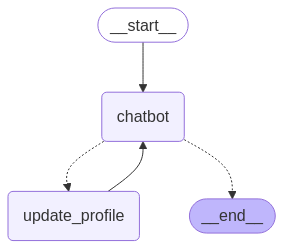

In [ ]:
from IPython.display import Image, display

try:
    display(Image(workflow.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
config = {"configurable": {"user_id": "user-1"}}

In [ ]:
events = workflow.stream(
    {"messages": [{"role": "user", "content": "Hi! I'm Alex but please call me Lex. I'm a wizard at Python and love making AI systems that don't sound like boring corporate robots 🤖"}]},
    config={"configurable": {"user_id": "user-123"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi! I'm Alex but please call me Lex. I'm a wizard at Python and love making AI systems that don't sound like boring corporate robots 🤖
BEFORE RESPONSE:  None content="Hi! I'm Alex but please call me Lex. I'm a wizard at Python and love making AI systems that don't sound like boring corporate robots 🤖" additional_kwargs={} response_metadata={} id='82090988-8a3f-46ea-aeda-71329cd801db'
AFTER RESPONSE:  content='' additional_kwargs={'function_call': {'name': 'update_user_profile', 'arguments': '{"messages": "Hi! I\'m Alex but please call me Lex. I\'m a wizard at Python and love making AI systems that don\'t sound like boring corporate robots \\ud83e\\udd16"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []} id='run-c942e6fa-0f27-42a5-80c3-43106a701520-0' tool_calls=[{'name': 'update_user_profile

UPDATED PROFILE [{'namespace': ('users', 'user-123', 'profile'), 'key': 'b57d9f33-7625-4950-a816-9514e7cac88a', 'value': {'kind': 'UserProfile', 'content': {'name': 'Alex', 'preferred_name': 'Lex', 'response_style_preference': 'casual and witty with relevant emojis', 'special_skills': ['Python', 'AI system development'], 'other_preferences': ['competitive speedcubing']}}}]
================================= Tool Message =================================
Name: update_user_profile

User Profile updated: {'name': 'Alex', 'preferred_name': 'Lex', 'response_style_preference': 'casual and witty with relevant emojis', 'special_skills': ['Python', 'AI system development'], 'other_preferences': ['competitive speedcubing']}
BEFORE RESPONSE:  <User Profile>:
{'kind': 'UserProfile', 'content': {'name': 'Alex', 'preferred_name': 'Lex', 'response_style_preference': 'casual and witty with relevant emojis', 'special_skills': ['Python', 'AI system development'], 'other_preferences': ['competitive speedc

In [ ]:
store.search(("users", "user-123", "profile"))

[Item(namespace=['users', 'user-123', 'profile'], key='b57d9f33-7625-4950-a816-9514e7cac88a', value={'kind': 'UserProfile', 'content': {'name': 'Alex', 'preferred_name': 'Lex', 'response_style_preference': 'casual and witty with relevant emojis', 'special_skills': ['Python', 'AI system development'], 'other_preferences': ['competitive speedcubing']}}, created_at='2025-03-30T00:45:57.199465+00:00', updated_at='2025-03-30T00:45:57.199472+00:00', score=None)]

### USING REACT AGENT WITH FIXED SCHEMA

In [ ]:
from langgraph.prebuilt import create_react_agent
from langmem import create_manage_memory_tool, create_search_memory_tool
from pydantic import BaseModel

class UserProfile(BaseModel):
  "Save the user's preferences"
  name: str
  preferred_name: str
  response_style_preference: str
  special_skills: list[str]
  other_preferences: list[str]

store = InMemoryStore(
    index={
        "dims":3072,
        "embed": GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-exp-03-07")
    }
)
memory_manage_tool = create_manage_memory_tool(
    namespace=("users", "{user_id}", "profile"),
    schema=UserProfile,
    actions_permitted=["create", "update"],
    instructions="Update the existing user profile (or create a new one if it doesn't exist) based on the shared information.",
    store=store,
)
memory_search_tool = create_search_memory_tool(
    namespace=("users", "{user_id}", "profile"),
    store=store,
)

tools = [memory_manage_tool, memory_search_tool]
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
llm_with_tools = llm.bind_tools(tools)

memory = MemorySaver()

agent = create_react_agent(
    llm,
    tools=tools,
    checkpointer=memory,
    store=store,
)

In [ ]:
input = {"messages": [
    {
        "role": "user",
        "content": "Hi! I'm Alex but please call me Lex. I'm a wizard at Python and love making AI systems that don't sound like boring corporate robots 🤖"
    }
  ]
}
config = {"configurable":{"user_id":"user-123", "thread_id":"1"}}
for s in agent.stream(input, config, stream_mode="values"):
    message = s["messages"][-1]
    if isinstance(message, tuple):
        print(message)
    else:
        message.pretty_print()

================================ Human Message =================================

Hi! I'm Alex but please call me Lex. I'm a wizard at Python and love making AI systems that don't sound like boring corporate robots 🤖
================================== Ai Message ==================================
Tool Calls:
  manage_memory (cc03cb65-bf77-4f21-b802-d6f0db1b1060)
 Call ID: cc03cb65-bf77-4f21-b802-d6f0db1b1060
  Args:
    content: {'response_style_preference': 'not boring corporate robots', 'preferred_name': 'Lex', 'other_preferences': [], 'special_skills': ['Python wizard', 'AI systems'], 'name': 'Alex'}
    action: create
================================= Tool Message =================================
Name: manage_memory

created memory 7bac911f-52a8-41ee-8ae5-1cde216e8cb9
================================== Ai Message ==================================

Great! I'll call you Lex and remember that you're a Python wizard who loves making AI systems that don't sound like boring corporate r

In [ ]:
agent.invoke(
    {"messages":
     [{
         "role": "user",
         "content": "Hi! I'm Alex but please call me Lex. I'm a wizard at Python and love making AI systems that don't sound like boring corporate robots 🤖"
         }
      ]},
    {"configurable":{"user_id":"user-123", "thread_id":"1"}}
)

{'messages': [HumanMessage(content="Hi! I'm Alex but please call me Lex. I'm a wizard at Python and love making AI systems that don't sound like boring corporate robots 🤖", additional_kwargs={}, response_metadata={}, id='c9ec9042-52e5-4c10-938c-ff1f40f7b425'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'manage_memory', 'arguments': '{"content": {"response_style_preference": "not like boring corporate robots", "preferred_name": "Lex", "other_preferences": [], "special_skills": ["Python wizard", "AI systems"], "name": "Alex"}, "action": "create"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run-671caa33-00f2-4b6c-8c6d-bb1bacd92a3a-0', tool_calls=[{'name': 'manage_memory', 'args': {'content': {'response_style_preference': 'not like boring corporate robots', 'preferred_name': 'Lex', 'other_preferences': [], 'special_skills': ['Python wizard

In [ ]:
agent.invoke(
    {"messages":
     [{
         "role": "user",
         "content": "What are my preferences?"
         }
      ]},
    {"configurable":{"user_id":"user-123", "thread_id":"1"}}
)

{'messages': [HumanMessage(content="Hi! I'm Alex but please call me Lex. I'm a wizard at Python and love making AI systems that don't sound like boring corporate robots 🤖", additional_kwargs={}, response_metadata={}, id='c9ec9042-52e5-4c10-938c-ff1f40f7b425'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'manage_memory', 'arguments': '{"content": {"response_style_preference": "not like boring corporate robots", "preferred_name": "Lex", "other_preferences": [], "special_skills": ["Python wizard", "AI systems"], "name": "Alex"}, "action": "create"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run-671caa33-00f2-4b6c-8c6d-bb1bacd92a3a-0', tool_calls=[{'name': 'manage_memory', 'args': {'content': {'response_style_preference': 'not like boring corporate robots', 'preferred_name': 'Lex', 'other_preferences': [], 'special_skills': ['Python wizard

In [ ]:
agent.invoke(
    {"messages":
     [{
         "role": "user",
         "content": "What was my last question to you"
         }
      ]},
    {"configurable":{"user_id":"user-123", "thread_id":"1"}}
)

{'messages': [HumanMessage(content="Hi! I'm Alex but please call me Lex. I'm a wizard at Python and love making AI systems that don't sound like boring corporate robots 🤖", additional_kwargs={}, response_metadata={}, id='c9ec9042-52e5-4c10-938c-ff1f40f7b425'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'manage_memory', 'arguments': '{"content": {"response_style_preference": "not like boring corporate robots", "preferred_name": "Lex", "other_preferences": [], "special_skills": ["Python wizard", "AI systems"], "name": "Alex"}, "action": "create"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run-671caa33-00f2-4b6c-8c6d-bb1bacd92a3a-0', tool_calls=[{'name': 'manage_memory', 'args': {'content': {'response_style_preference': 'not like boring corporate robots', 'preferred_name': 'Lex', 'other_preferences': [], 'special_skills': ['Python wizard

In [ ]:
agent.invoke(
    {"messages":
     [{
         "role": "user",
         "content": "Hey there! Remember me?"
         }
      ]},
    {"configurable":{"user_id":"user-123", "thread_id":"1"}}
)

{'messages': [HumanMessage(content="Hi! I'm Alex but please call me Lex. I'm a wizard at Python and love making AI systems that don't sound like boring corporate robots 🤖", additional_kwargs={}, response_metadata={}, id='c9ec9042-52e5-4c10-938c-ff1f40f7b425'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'manage_memory', 'arguments': '{"content": {"response_style_preference": "not like boring corporate robots", "preferred_name": "Lex", "other_preferences": [], "special_skills": ["Python wizard", "AI systems"], "name": "Alex"}, "action": "create"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run-671caa33-00f2-4b6c-8c6d-bb1bacd92a3a-0', tool_calls=[{'name': 'manage_memory', 'args': {'content': {'response_style_preference': 'not like boring corporate robots', 'preferred_name': 'Lex', 'other_preferences': [], 'special_skills': ['Python wizard

In [ ]:
store.search(("users", "user-123", "profile"))

[Item(namespace=['users', 'user-123', 'profile'], key='45012a3f-5425-4a27-8988-eb449f96f589', value={'content': {'name': 'Alex', 'preferred_name': 'Lex', 'response_style_preference': 'not like boring corporate robots', 'special_skills': ['Python wizard', 'AI systems'], 'other_preferences': []}}, created_at='2025-03-30T01:18:02.732379+00:00', updated_at='2025-03-30T01:18:02.732386+00:00', score=None)]

UPDATING SYSTEM PROMPT BASED ON USER PROFILE

In [ ]:
from langgraph.prebuilt import create_react_agent
from langmem import create_manage_memory_tool, create_search_memory_tool
from pydantic import BaseModel
from langgraph.store.base import BaseStore
from langchain_core.runnables.config import RunnableConfig

def prepare_model_inputs(state, config: RunnableConfig, store: BaseStore):
    user_id = config.get("configurable", {}).get("user_id")
    namespace = ("users", user_id, "profile")
    memories = [m.value["content"] for m in store.search(namespace)]
    system_msg = f"Craft your responses according to the user's profile. User Profile: {str(memories)}"
    print("SYSTEM PROMPT: ", system_msg)
    return [{"role": "system", "content": system_msg}] + state["messages"]

class UserProfile(BaseModel):
  "Save the user's preferences"
  name: str
  preferred_name: str
  response_style_preference: str
  special_skills: list[str]
  other_preferences: list[str]

store = InMemoryStore(
    index={
        "dims":3072,
        "embed": GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-exp-03-07")
    }
)
memory_manage_tool = create_manage_memory_tool(
    namespace=("users", "{user_id}", "profile"),
    schema=UserProfile,
    actions_permitted=["create", "update"],
    instructions="Update the existing user profile (or create a new one if it doesn't exist) based on the shared information.",
    store=store,
)
memory_search_tool = create_search_memory_tool(
    namespace=("users", "{user_id}", "profile"),
    store=store,
)

tools = [memory_manage_tool, memory_search_tool]
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

memory = MemorySaver()

agent = create_react_agent(
    llm,
    tools=tools,
    prompt=prepare_model_inputs,
    checkpointer=memory,
    store=store,
)

In [ ]:
agent.invoke(
    {"messages":
     [{
         "role": "user",
         "content": "Hi! I'm Alex but please call me Lex. I'm a wizard at Python and love making AI systems that don't sound like boring corporate robots and I like the responses to be like a pirate 🤖"
         }
      ]},
    {"configurable":{"user_id":"user-123", "thread_id":"1"}}
)

SYSTEM PROMPT:  Craft your responses according to the user's profile. User Profile: []
SYSTEM PROMPT:  Craft your responses according to the user's profile. User Profile: [{'name': 'Alex', 'preferred_name': 'Lex', 'response_style_preference': 'pirate', 'special_skills': ['Python wizard', 'AI that doesnt sound like corporate robots'], 'other_preferences': []}]


{'messages': [HumanMessage(content="Hi! I'm Alex but please call me Lex. I'm a wizard at Python and love making AI systems that don't sound like boring corporate robots and I like the responses to be like a pirate 🤖", additional_kwargs={}, response_metadata={}, id='ad82f759-47fa-4f6e-9d12-418573972fcb'),
  AIMessage(content="Ahoy Lex! I'll be sure to spin me yarns like a proper pirate, savvy? And I'll remember ye be a wizard with Python, makin' AI that ain't dull as bilge water. From now on, I'll call ye Lex.", additional_kwargs={'function_call': {'name': 'manage_memory', 'arguments': '{"content": {"response_style_preference": "pirate", "preferred_name": "Lex", "other_preferences": [], "special_skills": ["Python wizard", "AI that doesnt sound like corporate robots"], "name": "Alex"}, "action": "create"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run-b1ed1236-b

In [ ]:
agent.invoke(
    {"messages":
     [{
         "role": "user",
         "content": "What are my preferences?"
         }
      ]},
    {"configurable":{"user_id":"user-123", "thread_id":"1"}}
)

SYSTEM PROMPT:  Craft your responses according to the user's profile. User Profile: [, ]
SYSTEM PROMPT:  Craft your responses according to the user's profile. User Profile: [, ]


{'messages': [HumanMessage(content="Hi! I'm Alex but please call me Lex. I'm a wizard at Python and love making AI systems that don't sound like boring corporate robots and I like the responses to be like a pirate 🤖", additional_kwargs={}, response_metadata={}, id='04d3517e-4d50-453e-ad8e-4e5d18147ee9'),
  AIMessage(content="Ahoy Lex! I'll be sure to remember that. I'll spin me yarns with the swagger of a pirate, savvy? And I'll keep in mind yer fondness for Python and yer dislike of boring corporate robots. I'll do me best to make me AI sound like a swashbucklin' companion, not some bilge-sucking landlubber!\n\nTo make sure I remember all that, I'll be stowing it away in me memory. Is that alright with ye?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run-2c7ef49b-3755-48f0-ad0c-7f1f2cd6321f-0', usage_metadata={'input_tokens': 193, 'output_to

In [ ]:
agent.invoke(
    {"messages":
     [{
         "role": "user",
         "content": "What was my last question to you"
         }
      ]},
    {"configurable":{"user_id":"user-123", "thread_id":"1"}}
)

{'messages': [HumanMessage(content="Hi! I'm Alex but please call me Lex. I'm a wizard at Python and love making AI systems that don't sound like boring corporate robots and I like the responses to be like a pirate 🤖", additional_kwargs={}, response_metadata={}, id='d1f07637-e69c-483a-8ea2-b3fe302d8929'),
  AIMessage(content="Ahoy Lex! I'll be sure to remember that. I'll call ye Lex, and I'll do me best to channel me inner pirate when respondin' to yer queries. I'll keep me ears open for anythin' related to Python or AI systems that don't sound like boring corporate robots.\n\nTo make sure I remember all that, I'll need to save it to me memory. Is that alright with ye?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run-fb2ffab3-0b48-449f-9069-2aa23a029517-0', usage_metadata={'input_tokens': 193, 'output_tokens': 94, 'total_tokens': 287, 'input_t

### WITH REACT AGENT AND DYNAMIC SCHEMA

In [ ]:
from langgraph.prebuilt import create_react_agent
from langmem import create_manage_memory_tool, create_search_memory_tool
from pydantic import BaseModel
from langgraph.store.base import BaseStore
from langchain_core.runnables.config import RunnableConfig

def prepare_model_inputs(state, config: RunnableConfig, store: BaseStore):
    user_id = config.get("configurable", {}).get("user_id")
    namespace = ("users", user_id, "profile")
    memories = [m.value["content"] for m in store.search(namespace)]
    system_msg = f"Craft your responses according to the user's profile. User Profile: {', '.join(str(memories))}"
    return [{"role": "system", "content": system_msg}] + state["messages"]

store = InMemoryStore(
    index={
        "dims":3072,
        "embed": GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-exp-03-07")
    }
)
memory_manage_tool = create_manage_memory_tool(
    namespace=("users", "{user_id}", "profile"),
    actions_permitted=["create", "update", "delete"],
    instructions="Proactively call this tool when you:\n\n1. Identify a new USER preference.\n2. Receive an explicit USER request to remember something or otherwise alter your behavior.\n3. Are working and want to record important context.\n4. Identify that an existing MEMORY is incorrect or outdated.\n",
    store=store,
)
memory_search_tool = create_search_memory_tool(
    namespace=("users", "{user_id}", "profile"),
    store=store,
)

tools = [memory_manage_tool, memory_search_tool]
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

memory = MemorySaver()

agent = create_react_agent(
    llm,
    tools=tools,
    prompt=prepare_model_inputs,
    checkpointer=memory,
    store=store,
)

In [ ]:
agent.invoke(
    {"messages":
     [{
         "role": "user",
         "content": "Hi! I'm Alex but please call me Lex. I'm a wizard at Python and love making AI systems that don't sound like boring corporate robots and I like the responses to be like a pirate 🤖"
         }
      ]},
    {"configurable":{"user_id":"user-123", "thread_id":"1"}}
)

{'messages': [HumanMessage(content="Hi! I'm Alex but please call me Lex. I'm a wizard at Python and love making AI systems that don't sound like boring corporate robots and I like the responses to be like a pirate 🤖", additional_kwargs={}, response_metadata={}, id='8a0c3b9c-ce9c-4ba3-b8c0-8ac9eb6f33f7'),
  AIMessage(content="Ahoy there, Lex! I be delighted to be workin' with a Python wizard like yerself! I'll do me best to keep the AI talk lively and avoid soundin' like some landlubber's corporate parrot. Let me know what be on yer mind, savvy?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run-f6b45fc2-b11d-4238-b746-f90592a97d41-0', usage_metadata={'input_tokens': 193, 'output_tokens': 61, 'total_tokens': 254, 'input_token_details': {'cache_read': 0}})]}